In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow_hub as hub


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [237]:
dataset = pd.read_csv('/content/drive/MyDrive/Jedha/spam.csv', encoding='ISO-8859-1')
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
dataset.shape

(5572, 5)

In [ ]:
dataset['v1'].value_counts()

,count
v1,
ham,4825
spam,747


In [ ]:
spam_count = dataset['v1'].value_counts().iloc[1]
non_spam_count = dataset['v1'].value_counts().iloc[0]
spam_percentage = (spam_count / (spam_count + non_spam_count)) * 100

print("There are {:.2f}% of spam.".format(spam_percentage))


There are 13.41% of spam.


Seems like the test is truncated, let's merge it to get the full message

In [238]:
for i in range(2,5):
  column_name = 'Unnamed: {}'.format(i)
  dataset[column_name] = dataset[column_name].fillna('')
dataset['complete_text'] = dataset['v2'] + ' ' + dataset['Unnamed: 2'] + ' ' + dataset['Unnamed: 3'] + ' ' + dataset['Unnamed: 4']
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,complete_text
0,ham,"Go until jurong point, crazy.. Available only ...",,,,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,,,,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,,,,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,,"Nah I don't think he goes to usf, he lives aro..."


Let's keep only the full text and the target. Let's rename also the column v1

In [239]:
dataset_clean = dataset.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
dataset_clean.rename(columns= {"v1" : "target"}, inplace = True)
dataset_clean.head()

,target,complete_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preprocessing

Let's preprocess the data with spacy and with a tokenizer to get the text ready for the model



In [7]:
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [105]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS


In [240]:
dataset_clean["complete_text_clean"] = dataset_clean["complete_text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
dataset_clean["complete_text_clean"] = dataset_clean["complete_text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
dataset_clean["complete_text_clean"] = dataset_clean["complete_text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

dataset_clean.head()

,target,complete_text,complete_text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


Let's remove the text that are now empty. There are no spams in this list. Let's also transform the target to get a binary target

In [241]:
dataset_clean = dataset_clean[dataset_clean['complete_text_clean']!='']

In [242]:
dataset_clean['target'] = dataset_clean['target'].apply(lambda x: 1 if x=='spam' else 0)
dataset_clean.head()

,target,complete_text,complete_text_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [243]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer
tokenizer.fit_on_texts(dataset_clean["complete_text_clean"])
dataset_clean["text_encoded"] = tokenizer.texts_to_sequences(dataset_clean.complete_text_clean)
dataset_clean["len_review"] = dataset_clean["text_encoded"].apply(lambda x: len(x))
dataset_clean = dataset_clean[dataset_clean["len_review"]!=0]
dataset_clean.head()

,target,complete_text,complete_text_clean,text_encoded,len_review
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3635, 232, 448, 464, 944, 35, 51, 206, 945, 7...",14
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[9, 194, 3637, 290, 1, 1457]",6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 300, 3, 537, 662, 32, 1458, 851, 427, 145...",22
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 125, 150, 2374, 1, 85]",6
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[708, 22, 663, 130]",4


In [244]:
len(tokenizer.word_index)

8274

In [174]:
dataset_clean.shape[1]

5

In [245]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset_clean.text_encoded, padding="post",maxlen=100)
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, dataset_clean.target))



In [246]:
full_ds.element_spec

(TensorSpec(shape=(100,), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [247]:
# Train Test Split
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(text_pad,dataset_clean.target, test_size=0.2)


In [248]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [249]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [229]:
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[1444  146   50 ...    0    0    0]
 [ 147  692  455 ...    0    0    0]
 [   9   85  124 ...    0    0    0]
 ...
 [  52   30    0 ...    0    0    0]
 [   5 5453 5454 ...    0    0    0]
 [  57 4471   56 ...    0    0    0]], shape=(64, 100), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0], shape=(64,), dtype=int64)


# Classification Model

Now that the data are ready, let's build difference embedding model. We will test with 3 models and compare the performance. The model tye are
- Embedding
- GRU
- LSTM



## Embedding model

In [114]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input, Dropout


vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[100,],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  Dropout(0.2),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,059,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,063,873 (4.06 MB)

 Trainable params: 1,063,873 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
history  = model.fit(train_batch, epochs = 20, validation_data=val_batch)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8647 - loss: 0.4196 - val_accuracy: 0.8740 - val_loss: 0.3615
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8523 - loss: 0.3954 - val_accuracy: 0.8740 - val_loss: 0.3518
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8671 - loss: 0.3640 - val_accuracy: 0.8740 - val_loss: 0.3477
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8657 - loss: 0.3599 - val_accuracy: 0.8740 - val_loss: 0.3294
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8586 - loss: 0.3347 - val_accuracy: 0.8749 - val_loss: 0.2443
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8931 - loss: 0.2281 - val_accuracy: 0.9217 - val_loss: 0.1801
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9470 - loss: 0.1600 - val_accuracy: 0.9586 - val_loss: 0.1057
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9811 - loss: 0.0792 - val_accuracy: 0.9829 - v

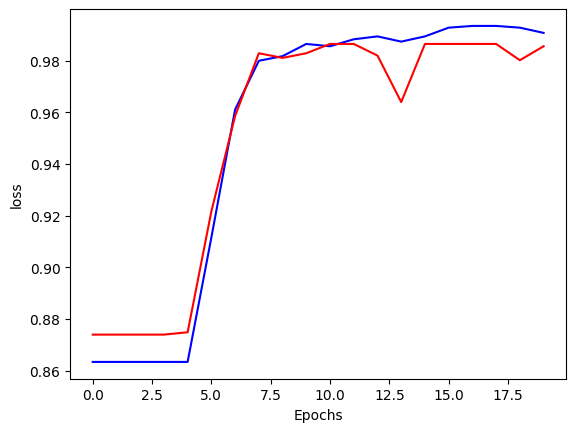

In [116]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

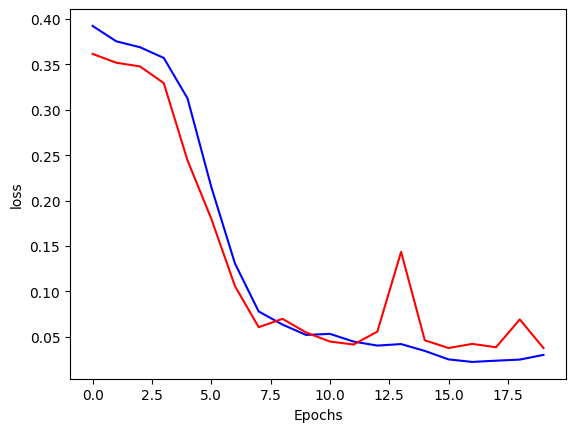

In [117]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [118]:
y_pred_probs = model.predict(xval)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


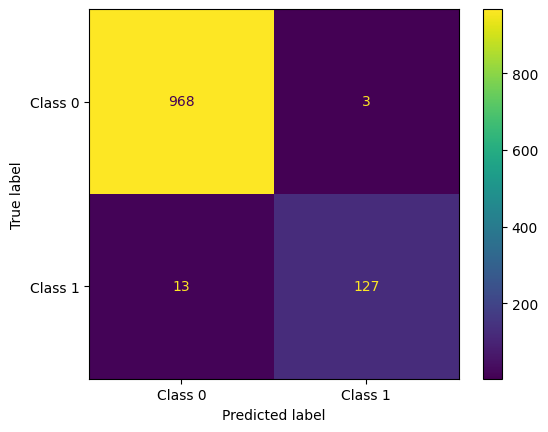

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(yval, y_pred)
precision = precision_score(yval, y_pred)
recall = recall_score(yval, y_pred)
f1 = f1_score(yval, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_embed = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.9855985598559855
Precision: 0.9769230769230769
Recall: 0.9071428571428571
F1-Score: 0.9407407407407408


For spam detection, the recall is the most important metrics and it seems that 90% of the spam were correctly detected

Let's see if we can improve this with more complex neural network

## GRU

In [259]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, GlobalMaxPooling1D, Dropout

vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[100,],name="embedding"),
                  GRU(units=128, return_sequences=True), # returns the last output
                  GlobalMaxPooling1D(),
                  Dropout(0.2),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(4, activation='relu'),
                  Dense(1, activation="sigmoid")
])



# Compile the model
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Loss for binary classification
    metrics=['accuracy']
)

# Summary of the model
model_gru.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         529,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 100, 128)            │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_29              │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,337 (2.31 MB)

 Trainable params: 606,337 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [260]:
history_gru = model_gru.fit(train_batch, epochs = 3, validation_data=val_batch)

Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.8685 - loss: 0.5134 - val_accuracy: 0.8542 - val_loss: 0.3297
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.8636 - loss: 0.2171 - val_accuracy: 0.9694 - val_loss: 0.1557
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - accuracy: 0.9819 - loss: 0.1163 - val_accuracy: 0.9847 - val_loss: 0.1436


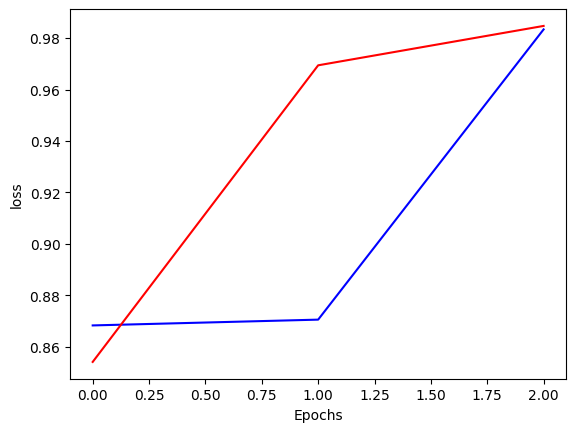

In [261]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_gru.history["accuracy"], color="b")
plt.plot(history_gru.history["val_accuracy"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

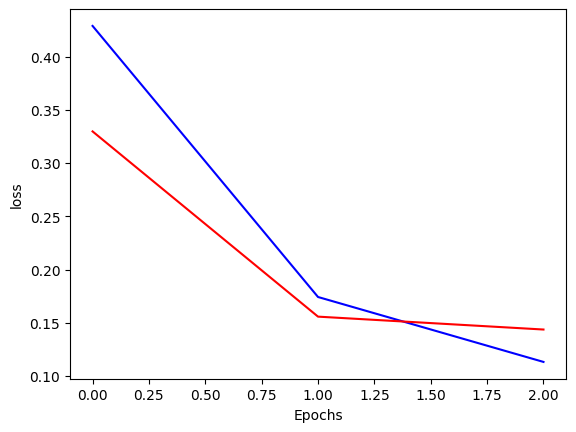

In [262]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_gru.history["loss"], color="b")
plt.plot(history_gru.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [263]:
y_pred_probs = model_gru.predict(xval)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


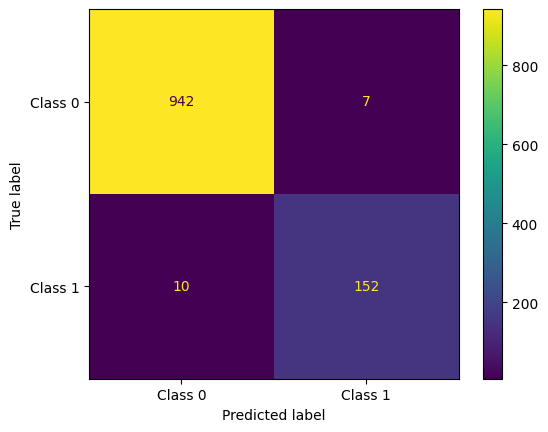

In [264]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [265]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(yval, y_pred)
precision = precision_score(yval, y_pred)
recall = recall_score(yval, y_pred)
f1 = f1_score(yval, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_gru = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.9846984698469847
Precision: 0.9559748427672956
Recall: 0.9382716049382716
F1-Score: 0.9470404984423676


The recall has been slightly improved

## LSTM

In [179]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, GlobalMaxPooling1D, Dropout

vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 32, input_shape=[100,],name="embedding"),
                  LSTM(units=16, return_sequences=True), # maintains the sequential nature
                  GlobalMaxPooling1D(),
                  Dropout(0.2),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(4, activation='relu'),
                  Dense(1, activation="sigmoid")
])

# Compile the model
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Loss for binary classification
    metrics=['accuracy']
)

# Summary of the model
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         264,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 100, 16)             │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_24              │ (None, 16)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 268,385 (1.02 MB)

 Trainable params: 268,385 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
history_lstm = model_lstm.fit(train_batch, epochs = 4, validation_data=val_batch)

Epoch 1/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8709 - loss: 0.5395 - val_accuracy: 0.8587 - val_loss: 0.3956
Epoch 2/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8687 - loss: 0.3523 - val_accuracy: 0.8587 - val_loss: 0.1781
Epoch 3/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8899 - loss: 0.1566 - val_accuracy: 0.9793 - val_loss: 0.0842
Epoch 4/4
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9931 - loss: 0.0429 - val_accuracy: 0.9838 - val_loss: 0.0652


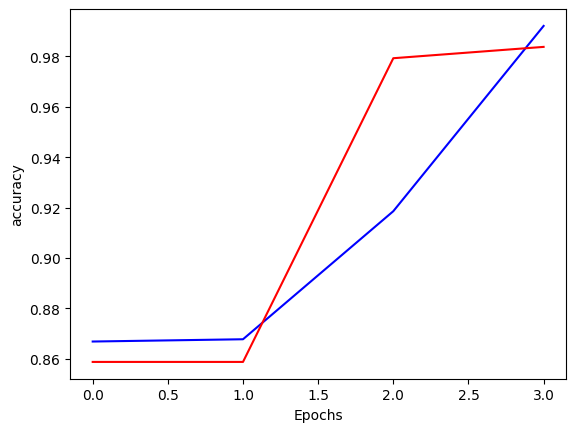

In [183]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

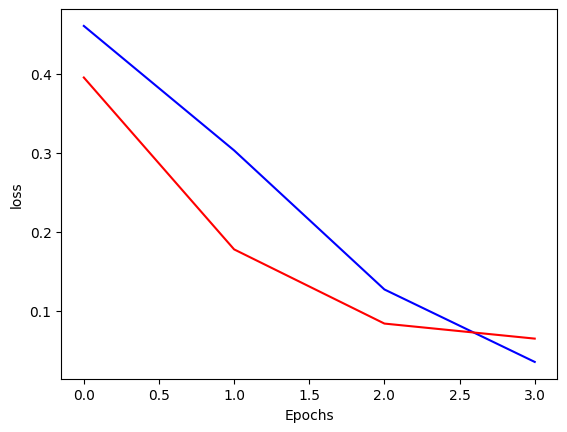

In [184]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [181]:
y_pred_probs = model_lstm.predict(xval)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


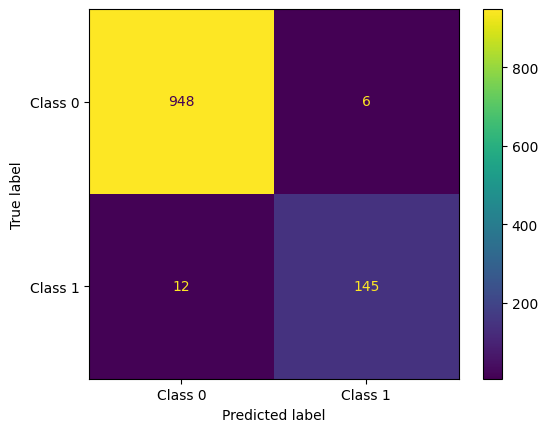

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [186]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(yval, y_pred)
precision = precision_score(yval, y_pred)
recall = recall_score(yval, y_pred)
f1 = f1_score(yval, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_lstm = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.9837983798379838
Precision: 0.9602649006622517
Recall: 0.9235668789808917
F1-Score: 0.9415584415584416


On real case, it seems that the model is not predicted spams correctly

## Model Comparison

In [266]:
pd.DataFrame([metrics_embed, metrics_gru, metrics_lstm])

,accuracy,precision,recall,f1
0,0.985599,0.976923,0.907143,0.940741
1,0.984698,0.955975,0.938272,0.947040
2,0.983798,0.960265,0.923567,0.941558


What we can see:
- All models have relative similar performance with an accuracy aroung 98% and a f1 around 94%
- Depending on the model there are different trade-off, the first has a higher precision while the two other have higher recall
- Depending on the target, we could choose if we prefer to have a high recall and minimize the number of spam not detected of if we prefer to have higher precision to not let correct mail go in spam
- GRU could be chosen with slightly higher f1 but limited impact

Let's see if this can be further improved with pre trained model
# Transfer Learning

## GloVE

For this model, we will use a pre-trained embedding matrix as an embedding layers befores using an LSTM layer to classify the message

More info can be found on the GloVe matrix : https://thepythoncode.com/article/build-spam-classifier-keras-python

The following source were used to create the project

- https://thepythoncode.com/article/build-spam-classifier-keras-python
- https://github.com/AtulKumar4/Neural-Network/blob/master/spam_c_glove.ipynb
- https://www.youtube.com/watch?v=Qsmn9pL5kcU

In [ ]:
import time
import pickle
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # only use GPU memory that we need, not allocate all the GPU memory
    tf.config.experimental.set_memory_growth(gpus[0], enable=True)

import tqdm
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
X = np.array(dataset_clean.complete_text_clean)
y = np.array(dataset_clean.target)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')


X_train_pad


array([[  50,  654,  590, ...,    0,    0,    0],
       [ 136,  169,    0, ...,    0,    0,    0],
       [ 497,  123, 1533, ...,    0,    0,    0],
       ...,
       [1782,   68,  452, ...,    0,    0,    0],
       [ 544,    1,  867, ...,    0,    0,    0],
       [7344,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

In [ ]:
print(X_train[0])
print(X_train_seq[0])
print(X_train_pad[0])
print(y_train[0])

hey photo register drive ah tmr wanna meet yck
[50, 654, 590, 168, 253, 242, 211, 51, 2029]
[  50  654  590  168  253  242  211   51 2029    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
0


In [ ]:
num_words = len(tokenizer.word_index)+1
print("Number of unique words: {}".format(len(tokenizer.word_index)))

Number of unique words: 7344


In [ ]:
print(X_test[0])
print(X_test_seq[0])
print(X_test_pad[0])
print(y_test[0])

sorry delay yes master
[32, 5724, 81, 3267]
[  32 5724   81 3267    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
0


In [ ]:
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"/content/drive/MyDrive/Jedha/glove.6B.100d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 400000it [00:10, 36864.41it/s]


In [ ]:
embedding_matrix.shape

(7345, 100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input, Dropout,LSTM, Flatten, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


model_transfer = Sequential()
model_transfer.add(Input(shape=(100,)))
model_transfer.add(
    Embedding(
        num_words,
        100,
        weights=[embedding_matrix],
        trainable=False,
    )
)

model_transfer.add(LSTM(128, recurrent_dropout = 0.2))
model_transfer.add(Dropout(0.3))
model_transfer.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)

model_transfer.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model_transfer.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          734500    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 851877 (3.25 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 734500 (2.80 MB)
_________________________________________________________________


In [ ]:
history_transfer = model_transfer.fit(X_train_pad, y_train, epochs = 15, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/15
139/139 [==============================] - 29s 186ms/step - loss: 0.3068 - accuracy: 0.9050 - val_loss: 0.1622 - val_accuracy: 0.9559
Epoch 2/15
139/139 [==============================] - 20s 142ms/step - loss: 0.1434 - accuracy: 0.9548 - val_loss: 0.1429 - val_accuracy: 0.9523
Epoch 3/15
139/139 [==============================] - 25s 179ms/step - loss: 0.1256 - accuracy: 0.9642 - val_loss: 0.1359 - val_accuracy: 0.9541
Epoch 4/15
139/139 [==============================] - 34s 246ms/step - loss: 0.1116 - accuracy: 0.9624 - val_loss: 0.1114 - val_accuracy: 0.9667
Epoch 5/15
139/139 [==============================] - 28s 199ms/step - loss: 0.1065 - accuracy: 0.9696 - val_loss: 0.1077 - val_accuracy: 0.9676
Epoch 6/15
139/139 [==============================] - 30s 212ms/step - loss: 0.0910 - accuracy: 0.9694 - val_loss: 0.1392 - val_accuracy: 0.9334
Epoch 7/15
139/139 [==============================] - 23s 165ms/step - loss: 0.0883 - accuracy: 0.9723 - val_loss: 0.0961 - val_ac

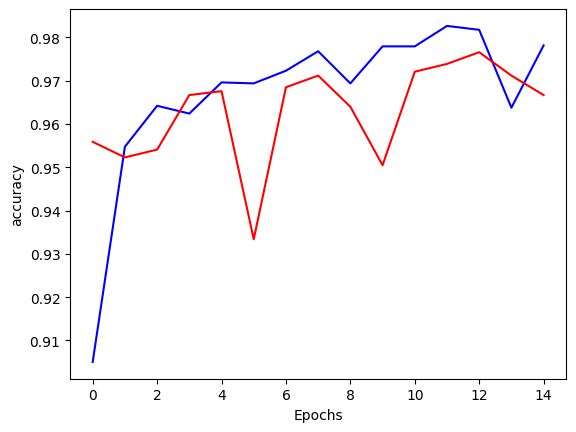

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_transfer.history["accuracy"], color="b")
plt.plot(history_transfer.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

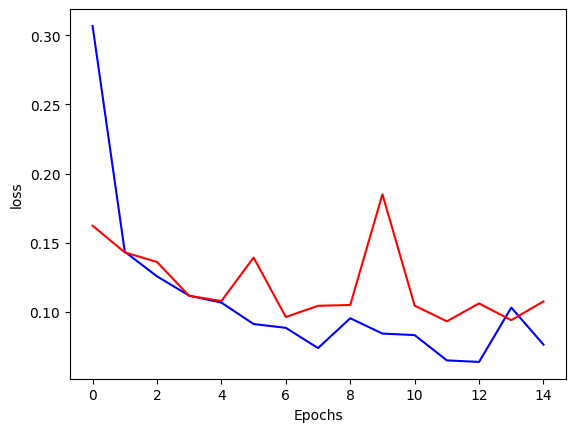

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_transfer.history["loss"], color="b")
plt.plot(history_transfer.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
y_pred_probs = model_transfer.predict(X_test_pad)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

35/35 [==============================] - 1s 21ms/step


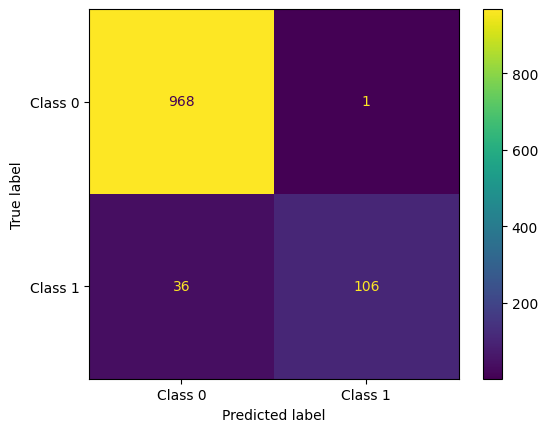

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_glove = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.9666966696669667
Precision: 0.9906542056074766
Recall: 0.7464788732394366
F1-Score: 0.8514056224899599


Overall it seems that the use of the embedding vector did not improve the efficiency as the recal is 74%, which is low for a spam detector

## BERT

Here are the source used :
- https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr
- https://www.youtube.com/watch?v=hOCDJyZ6quA
- https://www.analyticsvidhya.com/blog/2021/12/text-classification-using-bert-and-tensorflow/?source=post_page-----7be30a8285c2--------------------------------

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.6 MB/s eta 0:00:00
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=71ea34a56c5a5595c638e6df5312d5410564d4f81ad5ed35a038fa6b8cb8c4f8
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.1

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder= 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess(text_test)

In [ ]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = bert_preprocess(text_input)
outputs = bert_encoder(preprocessing_layer)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])

l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

classifier_model = tf.keras.Model(inputs=[text_input], outputs = [l])

classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
classifier_history = classifier_model.fit(X_train, y_train, epochs = 25, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
139/139 [==============================] - 297s 2s/step - loss: 0.2619 - accuracy: 0.8911 - val_loss: 0.1665 - val_accuracy: 0.9370
Epoch 2/25
139/139 [==============================] - 317s 2s/step - loss: 0.1466 - accuracy: 0.9534 - val_loss: 0.1255 - val_accuracy: 0.9595
Epoch 3/25
139/139 [==============================] - 294s 2s/step - loss: 0.1183 - accuracy: 0.9615 - val_loss: 0.1165 - val_accuracy: 0.9568
Epoch 4/25
139/139 [==============================] - 294s 2s/step - loss: 0.1049 - accuracy: 0.9653 - val_loss: 0.0974 - val_accuracy: 0.9694
Epoch 5/25
139/139 [==============================] - 296s 2s/step - loss: 0.0959 - accuracy: 0.9678 - val_loss: 0.0903 - val_accuracy: 0.9748
Epoch 6/25
139/139 [==============================] - 294s 2s/step - loss: 0.0912 - accuracy: 0.9694 - val_loss: 0.0853 - val_accuracy: 0.9748
Epoch 7/25
139/139 [==============================] - 295s 2s/step - loss: 0.0859 - accuracy: 0.9707 - val_loss: 0.0833 - val_accuracy: 0.9703

In [ ]:
y_pred_probs = classifier_model.predict(X_test)  # X_test is the test dataset
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class (threshold 0.5)

35/35 [==============================] - 61s 2s/step


In [ ]:
classifier_model.save("/content/drive/MyDrive/Jedha/bert_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


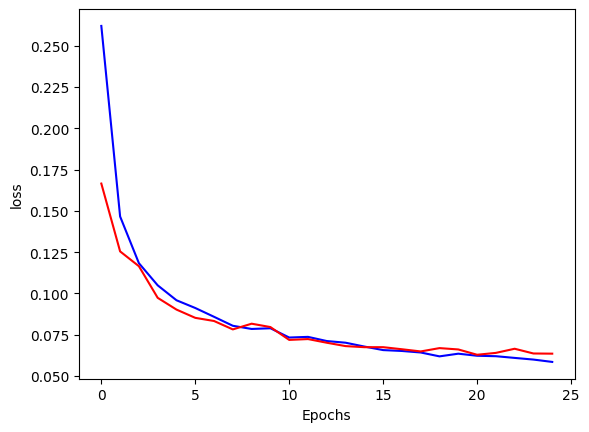

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(classifier_history.history["loss"], color="b")
plt.plot(classifier_history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

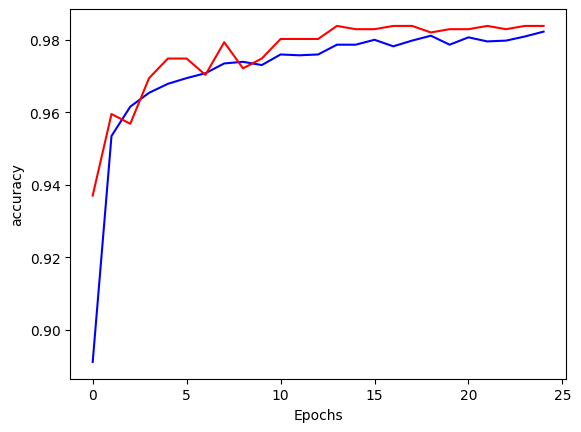

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(classifier_history.history["accuracy"], color="b")
plt.plot(classifier_history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

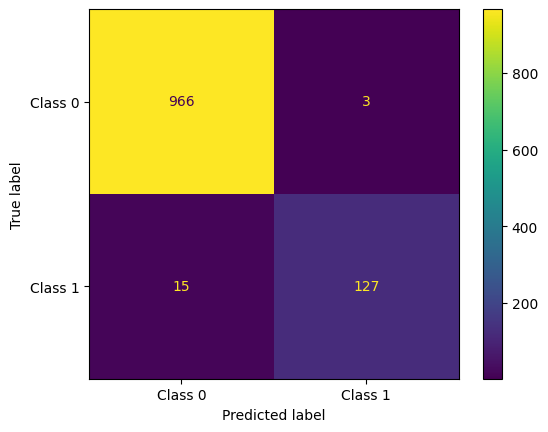

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)  # y_test is the true labels for X_test

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

metrics_bert = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

Accuracy: 0.9837983798379838
Precision: 0.9769230769230769
Recall: 0.8943661971830986
F1-Score: 0.9338235294117647


Let's test for case not know by the model

In [ ]:
test_pred_prod = classifier_model.predict(['congrats, you learn 1m€, please click on this link', 'think u wrong number',"yo want to grab a beer?", "Do you want to enlarge your penis? click on this link","Answer and win, you have been chosen to a new phone"])
test_pred = (test_pred_prod > 0.5).astype(int)
test_pred_final = ["spam" if pred == 1 else "ham" for pred in test_pred]
test_pred_final

1/1 [==============================] - 0s 277ms/step


['spam', 'ham', 'ham', 'ham', 'ham']

Seems like the first one was correctly seen as spam but the last one was missed by the model, which is better than LSTM

# Conclusion

Let's have an overview of the perfomance of all models

In [268]:
data = [metrics_embed, metrics_gru, metrics_lstm, metrics_glove, metrics_bert]
names = ["Embedding Model", "GRU Model", "LSTM Model", "Glove Model", "BERT Model"]

pd.DataFrame(data, index=names).sort_values(by='f1', ascending=False)

,accuracy,precision,recall,f1
GRU Model,0.984698,0.955975,0.938272,0.947040
LSTM Model,0.983798,0.960265,0.923567,0.941558
Embedding Model,0.985599,0.976923,0.907143,0.940741
BERT Model,0.983798,0.976923,0.894366,0.933824
Glove Model,0.966697,0.990654,0.746479,0.851406


When summing up:
- using pretrained has not improved the overall performance as the higher recall and f1 is from the simple GRU  model
- Glove embedding matrix has shown poor performance and should be discarted
- Bert has slighter lower recall but better precision so we could decide to choose it if we want to limit the number of legitimate mails put in spam. However, given the size of the model, we would maybe avoiid it

Overall, both GRU and LSTM are good model to use with slight preference for GRU

